#####**Package import**

In [71]:
import pandas as pd

import plotly.express as px #for visualization
import matplotlib.pyplot as plt #for visualization 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#####**Data overview**

The data set comes from [Kaggle](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset). It is related to the customers in ABC Multistate bank. The classification goal is to predict whether the custormer will churn or not. 


Let first load the data, print the first five rows then get overview of the dataset.

In [72]:
df = pd.read_csv('data.csv')

df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [73]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000



The dataset includes information 10000 of bank customers and 12 features. The first column is **customer_id** which won't be used in the model so we can drop it.

In [74]:
#Get overview of the data
def dataoveriew(df, message):
    print(f'{message}:\n')
    print('Number of rows: ', df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nData Features:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())
    
dataoveriew(df, 'Overview of the dataset')

Overview of the dataset:

Number of rows:  10000

Number of features: 12

Data Features:
['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn']

Missing values: 0

Unique values:
customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64


There are 2 categorical features:


*   **country**: Country of residence (France, Spain, Germany)
*   **gender**: Customer's gender (Male, Female)

There are 8 numerical features:


*   **credit_score**: Indicate customer's creditworthiness (range from 350->850)
*   **age**: Customer's age (range from 18->92)
*   **tenure**: How many years the customer is having bank account in ABC bank.
*   **balance**: The amount of money a customer has available in customer's account.
*   **products_number**: Number of services offered by the bank to the customer.
*   **credit_card**: Is the customer have credit card or not (1 if he/she has credit card, 0 if he/she has not)
*   **active_member**: Is the customer is active member of the bank?
*   **estimated_salary**: estimated the customer's salary.

Finally, there's a prediction feature:
*   **churn**: Whether the customer churned or not (`churn = 1` if the customer has left the bank during some period or `churn = 0` if he/she has not)


#####**EDA**

Firstly, we will explore the target variable. We’re trying to predict which customer will churn. It’s a binary classification problem with an unbalanced target.

*   Churn: No – 79.6%
*   Churn: Yes – 20.4%



In [75]:
target_instance = df['churn'].value_counts().to_frame()
target_instance = target_instance.reset_index()
target_instance = target_instance.rename(columns={'index': 'Category'})
target_instance.loc[target_instance.Category==0,'Category'] = "No"
target_instance.loc[target_instance.Category==1,'Category'] = "Yes"
fig = px.pie(target_instance, values='churn', names='Category', color_discrete_sequence=["green", "red"],
             title='Distribution of Churn')
fig.show()

**Exploring features**

Let's explore the demographic features

In [76]:
def bar(feature, df=df):
  #Group the categorical by feature
  df_group = df.groupby([feature, 'churn']).size().reset_index()
  df_group.rename(columns={0:'count'}, inplace=True)

  #Convert the target value 
  df_group.loc[df_group.churn==0, 'churn'] = 'No'
  df_group.loc[df_group.churn==1, 'churn'] = 'Yes'

  df_sum = df_group.groupby([feature])['count'].sum().reset_index()
  df_sum.rename(columns={'count':'sum'}, inplace=True)

  #Calculate rate of churn in each feature category
  df_group = pd.merge(df_group, df_sum, how='inner')
  df_group['rate'] = round(100*df_group['count']/df_group['sum'],2).astype(str) + '%'

  #Setting graph
  fig = px.bar(df_group, x=feature, y='count', color='churn', title=f'Churn rate by {feature}',
               barmode='group', color_discrete_sequence=['green','red'], hover_data=['rate'])
  
  return fig.show()
  

In [77]:
bar('gender')
bar('country')

In [78]:
# Defining the histogram plotting function
def hist(feature):
    df_group = df.groupby([feature, 'churn']).size().reset_index()
    df_group = df_group.rename(columns={0: 'count'})

    #Convert the target value 
    df_group.loc[df_group.churn==0, 'churn'] = 'No'
    df_group.loc[df_group.churn==1, 'churn'] = 'Yes'
    
    fig = px.histogram(df_group, x=feature, y='count', color='churn', marginal='box', title=f'Churn rate frequency to {feature} distribution', 
                       color_discrete_sequence=["green", "red"])
    fig.show()

**Demographic analysis insight**: The churn rate is slightly higher in female with 25% of female churned, while that rate in male is 16.5%. 

About 50% of the customers have country of residence is France. However, Germany customers are the most likely to churn with the churn rate is 33%.


In [79]:
hist('age')

Most of the customers in this dataset are in the age range of 30-40. More than a half of the customers who are in the age range of 50-60 tend to churn. The churn rate of customers are in the age range 40-50 is also high (31%).

Next, let's explore product ownership features

In [80]:
bar('tenure')
bar('products_number')
bar('credit_card')
bar('active_member')

Almost the customers have had bank account in ABC bank for 1-9 years. None active members have higher churn rate than active members. The customers who own 3-4 products from the bank have churn rate especialy high.

Finally, let's explore finacial related features

In [81]:
hist('credit_score')
hist('balance')
hist('estimated_salary')

Number of the customers have very small amount of balance (<1000) is specially high.

**Data preprocessing**

We will convert the data into a data representation suiltable for various machine learning algorithms. That means we will encoding the binary category to binary data [0,1], create dummy variables for categoric features with more than two categories.

In [82]:
#Drop customer_id column due to it is redundant in the model
df.drop(columns={'customer_id'}, inplace=True)

df['gender'] = df['gender'].map({'Male':1, 'Female':0})

df = pd.get_dummies(df)

In [83]:
df.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1


Let's see the correlation between the features. Features with high correlation are more linearly dependent and have almost the same effect on the dependent variable. So, when two features have a high correlation, we can drop one of them.

In [84]:

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain
credit_score,1.00,-0.00,-0.00,0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03,-0.01,0.01,0.00
gender,-0.00,1.00,-0.03,0.01,0.01,-0.02,0.01,0.02,-0.01,-0.11,0.01,-0.02,0.02
age,-0.00,-0.03,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29,-0.04,0.05,-0.00
tenure,0.00,0.01,-0.01,1.00,-0.01,0.01,0.02,-0.03,0.01,-0.01,-0.00,-0.00,0.00
balance,0.01,0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12,-0.23,0.40,-0.13
products_number,0.01,-0.02,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05,0.00,-0.01,0.01
credit_card,-0.01,0.01,-0.01,0.02,-0.01,0.00,1.00,-0.01,-0.01,-0.01,0.00,0.01,-0.01
active_member,0.03,0.02,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16,0.00,-0.02,0.02
estimated_salary,-0.00,-0.01,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01,-0.00,0.01,-0.01
churn,-0.03,-0.11,0.29,-0.01,0.12,-0.05,-0.01,-0.16,0.01,1.00,-0.10,0.17,-0.05


#####**Build Model**

Firstly, we will split the dataset into training set and test set

In [85]:
X = df.drop(columns={'churn'})
Y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Next, due to the dataset is imbalance so we will do re-sampling. Following we will do over-sampling on the training set using SMOTE.

In [86]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_train_resample, y_train_resample = sm.fit_resample(X_train, y_train)

Build the model using XGBoost algorithm

accuracy:  0.85
precision:  0.6
recall:  0.67
f1_score:  0.85


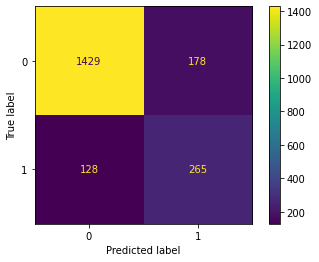

In [87]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=200, random_state=42)
#Fit data to the model
xgb_model.fit(X_train_resample, y_train_resample)
#use the model to predict for the test set
y_pred = xgb_model.predict(X_test)

Evaluate the model

accuracy:  0.85
precision:  0.6
recall:  0.67
f1_score:  0.85


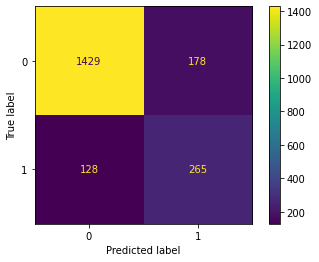

In [88]:
#Performance evaluation
def print_scores(y_true, y_pred):
    acc_score = metrics.accuracy_score(y_true, y_pred)
    print("accuracy: ",round(acc_score,2))
    pre_score = metrics.precision_score(y_true, y_pred)
    print("precision: ",round(pre_score,2))
    rec_score = metrics.recall_score(y_true, y_pred)                            
    print("recall: ",round(rec_score,2))
    f_score = metrics.f1_score(y_true, y_pred, average='weighted')
    print("f1_score: ",round(f_score,2))

print_scores(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=xgb_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_model.classes_).plot()
plt.show()